In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.188230  0.320804 -0.410505 -1.281596  0.322928  0.236467  0.603763   
  1   0.472394  0.475442 -0.441344  0.579380  0.780290 -0.963874 -0.546929   
  2  -0.378214 -0.466101  0.145499 -0.531495 -0.597530 -0.293357  0.486294   
  3  -0.875849  0.462096  0.836975 -0.946104 -0.446399 -0.107395  0.984827   
  4   0.552397 -0.376688  0.115493  0.230045  1.717997  0.422672 -0.466766   
  5  -0.095852 -0.714159 -0.193634  0.095212 -0.066265 -0.571277  1.061177   
  6  -0.141021 -1.125413 -0.917702 -0.226672  0.575811  1.017151  0.291378   
  7  -0.721287  0.095698 -0.442894 -0.362375  0.434604  0.547479 -0.101098   
  8   1.227453  0.546138 -0.435900 -0.481766 -0.434992  0.484485 -0.436861   
  9  -0.089566 -0.323515 -0.296016 -1.441346  0.436468 -0.724602  0.951193   
  10 -0.609818 -0.332634 -0.382562  0.395031 -0.637114 -0.364916 -0.552135   
  11 -0.437993 -1.303666 -1.845006 -0.998658  0.274077 -0.406752 -0.014212   
  12  0.681679 -0.182214 -0.524215  0.051705 -0.129351  0.185119  0.655136   
  13  0.642433  0.227650 -0.101502 -0.481300  0.215284  0.148396  0.925158   
  14 -0.281310  0.891524  0.799578  0.505847 -0.234560 -0.179579  0.461792   
  15  0.490686 -0.063316 -0.604808 -0.466565 -0.317864  0.797072  1.659932   
  16  0.561656  0.664010 -0.099969 -0.264381 -0.573997 -1.019685 -0.012453   
  17  0.374084  0.884398  0.505319  0.420783 -0.055353 -1.003158 -1.320813   
  18  0.409520 -0.080724 -0.679185  0.920376  0.020768 -0.837583 -0.907223   
  19 -1.158317 -0.050890 -0.915700 -0.670736 -0.077771  0.112820  0.401315   
  20  0.658523 -0.805693 -0.376988 -0.832934 -0.169184 -0.245451  0.315426   
  21  0.390149  0.689470 -0.171627 -0.604570 -0.165026  0.159615  0.103312   
  22  0.023888 -0.077013 -1.156263 -0.341264 -0.123052 -0.087535  0.406656   
  23  0.641536 -0.042957 -0.151613  0.685681  0.730977  0.389666 -0.234223   
  24  0.476342 -0.493185 -0.192702 -0.113322  0.751206  0.433144  1.125045   
1 0   0.588661  0.216944 -0.142794 -0.787022 -0.072607 -0.158794 -1.104362   
  1   0.536843  0.392490  0.388042  0.334203 -0.023235 -0.373867 -0.772625   
  2   0.202321  0.371322  0.821089 -0.270529  0.563064  0.467454 -0.329586   
  3   0.015665  0.906198 -0.166793 -0.987394 -0.988640 -0.192649 -0.185395   
  4   0.294348 -0.141741  0.011707 -0.496491  0.032546  0.037267  0.431284   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.829608  0.195909  0.472335  ... -0.252146  0.582310  0.148532   
  1  -0.300849 -0.110229 -0.765915  ...  0.646397  0.824726  0.557565   
  2   0.639137  0.488560 -0.451740  ... -0.789922 -0.339976  0.126465   
  3   0.774925  0.599219  0.454680  ...  0.321572  0.601591  0.235330   
  4   0.432727  0.152051 -0.461126  ...  0.208034  0.082580 -0.979831   
  5  -1.014119 -1.655782 -1.072923  ...  0.171538 -0.122113 -0.378865   
  6   0.070499  0.158396 -0.114119  ...  0.056004 -0.135889 -1.789700   
  7  -0.434648 -0.699113 -1.314318  ...  1.216341  0.740693  0.463326   
  8   0.899271  0.070637 -0.039666  ...  0.181743  0.917579 -0.507730   
  9   0.059086  0.270142 -0.139684  ... -0.352849  0.183702 -0.551255   
  10 -0.026972  0.043981 -0.330644  ... -0.704282  0.083478  0.810970   
  11  0.205560 -1.080094 -1.521868  ... -0.497820  0.236613  0.139122   
  12  0.714444  0.522218  0.377279  ...  0.492899  0.686639  0.577016   
  13  1.047190  0.853933  1.162248  ...  0.016427  0.110522  1.277720   
  14  0.273595  0.665335  0.121696  ... -0.278411 -0.859010  0.942562   
  15 -0.061404 -0.041473  0.090702  ...  0.264959 -0.508680 -0.538840   
  16 -0.235142 -0.465438  0.569478  ... -0.868704 -0.040380  0.326060   
  17  0.062461 -0.272053 -0.339415  ...  0.769576  0.206053  0.575747   
  18 -0.529275 -0.483110  0.911125  ...  0.065698  0.947121 -0.216497   
  19 -1.238521 -0.044724 -0.223600  ... -0.031452  1.044103 -0.235274   
  20  0.191089 -0.048659 -0.052092  ...  0.282886  0.765316 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err         t          P>|t|     2.5 %    97.5 %
D  1.066011  0.037138  28.70392  3.408824e-181  0.993222  1.138801


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



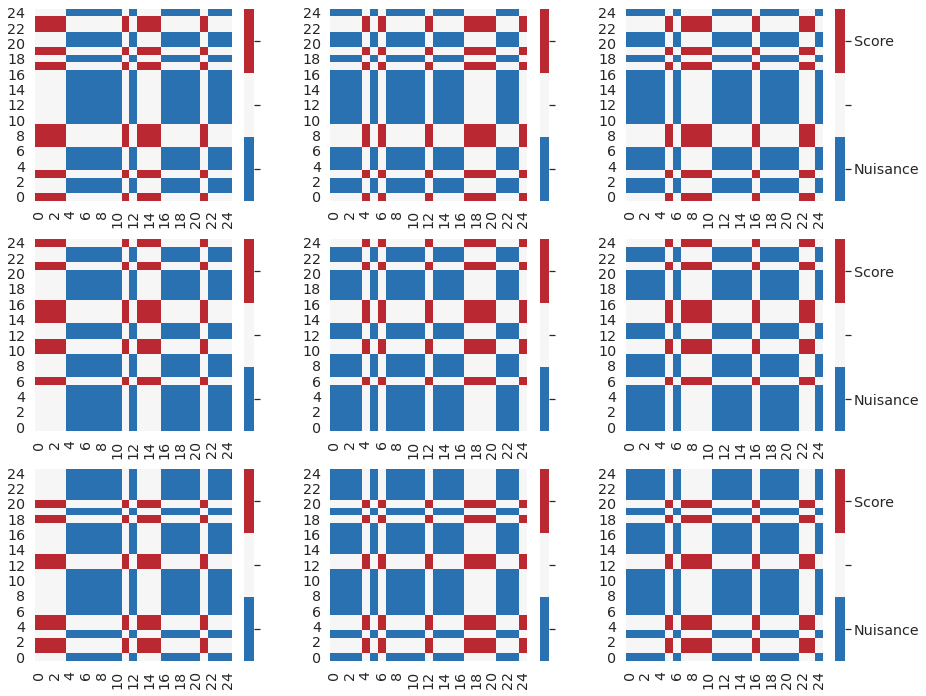

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



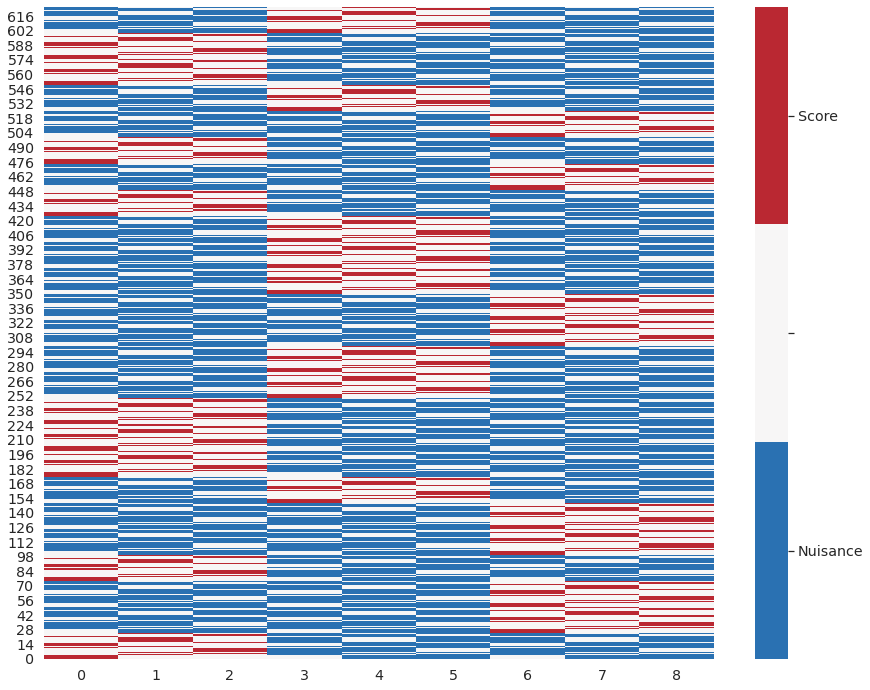

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])